## Load Quantile Construction (Merit-Order Proxy)

Electricity prices are strongly driven by **system load**.  
To analyze how prices behave under different levels of system stress, I first
transform the continuous load variable into **load quantiles**.

### Why quantiles?
- Absolute load levels change across seasons and years
- Quantiles represent **relative system stress**
- High quantiles ≈ peak / scarcity hours
- Low quantiles ≈ slack system conditions

In this step, I
 divide all hourly load observations into **10 equal-sized groups (deciles)**.
Each hour is assigned a load quantile from 1 (lowest load) to 10 (highest load).


In [85]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
base_dir = Path.cwd().parent
file= base_dir / "data"/"Final"/"load_price_clean.csv"  ## dataset path

In [3]:
#dataset contains the timestamp, load (mw) and price (eur/mwhr)
df=pd.read_csv(file)
df['timestamp']=pd.to_datetime(df['timestamp'])
df.set_index('timestamp',inplace=True)
# df.describe()


In [4]:
#Basic data check
# Check that the load column exists
if "price" and "load" not in df.columns.str.lower():
    raise ValueError("The dataset does not contain a 'load' or 'price' column")

# Check for missing load values
print("Missing load values:", df["load"].isna().sum()) 
print("Missing price values:", df["Price"].isna().sum())


Missing load values: 0
Missing price values: 0


<Axes: xlabel='timestamp'>

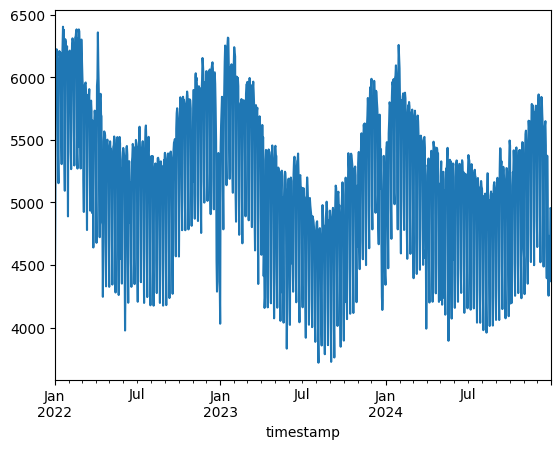

In [5]:
# before doing further analysis just visualize load change during three years
df['load'].resample('D').sum().plot()

### Interpretation of Load Quantiles

- Load quantile **1** represents the lowest 10% of system load hours  
- Load quantile **10** represents the highest 10% of system load hours (system stress)

In [60]:
# 3. Create load quantiles (dividing the load into 10  parts)
# ---------------------------------------------------
# I uses 10 quantiles (deciles), 

df["load_quantile"] = pd.qcut(df["load"],q=10,labels=False)

df["load_quantile"] = df["load_quantile"] + 1

# df[['load','load_quantile']]

#checking the output 
quantile_counts = df["load_quantile"].value_counts().sort_index()

# quantile_counts

load_quantile
1     10521
2     10520
3     10520
4     10521
5     10520
6     10520
7     10521
8     10520
9     10520
10    10521
Name: count, dtype: int64

In [12]:
# I want to see how the price behaves at different load levels
# So I'll group the data by load quantile and calculate the average price for each
avg_price_per_quantile= df.groupby('load_quantile')['Price'].mean()
# avg_price_per_quantile

In [13]:
#I also want to get a sense of variability, not just the mean
# So I'm calculating median, min, max, and standard deviation per quantile
price_stats_per_quantile = df.groupby("load_quantile")["Price"].agg(
    mean="mean",
    min="min",
    
    max="max",
    std="std",
    q25=lambda x: x.quantile(0.25),
    q75=lambda x: x.quantile(0.75),
    iqr=lambda x: x.quantile(0.75) - x.quantile(0.25)
)


# Checking the table to see if high load hours are more volatile
price_stats_per_quantile

,mean,min,max,std,q25,q75,iqr
load_quantile,,,,,,,
1,97.405078,-129.96,644.20,87.683265,61.9700,101.03,39.0600
2,112.432351,-132.85,700.00,104.841286,59.6475,116.14,56.4925
3,112.894090,-500.00,747.74,107.362025,56.8300,128.71,71.8800
4,112.472713,-500.00,762.48,102.934527,56.0800,134.27,78.1900
5,130.444498,-91.90,800.00,105.795905,70.3300,155.17,84.8400
6,147.246555,-19.04,860.89,116.457884,84.4925,163.48,78.9875
7,149.194532,-21.77,871.00,132.995407,79.9500,162.47,82.5200
8,149.783127,-42.95,820.11,125.388261,74.9375,189.08,114.1425
9,168.122455,-11.18,936.28,124.624366,84.8400,212.61,127.7700


## Analysis of Load-Conditional Price Curve

Looking at the curve, I can clearly see that the **average day-ahead price increases as the load quantile increases**.  
This makes sense because higher system load usually triggers more expensive generation units, so prices rise when the system is under stress.  

However, I also notice that **a few hours in the highest load quantiles still have negative prices**.  
This is interesting and can happen for several reasons:  
- Sometimes renewable generation is very high during peak load hours, causing oversupply  
- Market conditions can lead to negative pricing even when load is high  
- It shows that scarcity is not the only factor driving prices; supply fluctuations also matter  

Overall, the pattern confirms the **merit-order effect**: prices are generally low when the system is lightly loaded and rise as load increases.  
The variability (as seen from min, max, and standard deviation) also increases in higher quantiles, indicating that **peak load hours are more volatile and risky**.  

From a practical perspective, this analysis can be very useful for **capacity planning and risk assessment**:  
- Utilities can identify **critical load levels** where the system is likely to experience high prices or volatility and plan generation or demand response accordingly  
- Planners can evaluate the **need for additional capacity or flexible resources** to manage peak hours  
- Risk managers can use the price variability information to **develop hedging strategies** and prepare for extreme price events  

In short, this load-conditional price curve gives a **quantitative and visual understanding of market stress**, helping analysts make informed decisions about **system reliability, financial risk, and capacity adequacy**.


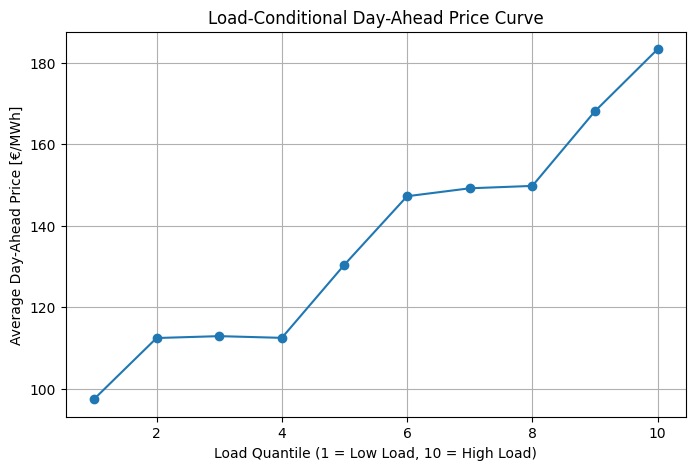

In [14]:

# I want to visualize the price response across the load quantiles
# This will help me see if prices spike at high load, which indicates scarcity pricing
plt.figure(figsize=(8,5))
plt.plot(avg_price_per_quantile.index, avg_price_per_quantile.values, marker='o', linestyle='-')
plt.title("Load-Conditional Day-Ahead Price Curve")
plt.xlabel("Load Quantile (1 = Low Load, 10 = High Load)")
plt.ylabel("Average Day-Ahead Price [€/MWh]")
plt.grid(True)
plt.show()

# From this plot, I can directly see which load levels cause higher prices
# This will be useful for market tightness and peak-hour risk analysis


In [15]:
#adding extra columns for further analysis
df['hour'] = df.index.hour
df['day'] = df.index.weekday  # 0 = Monday, 6 = Sunday
df['month'] = df.index.month

In [16]:
hourly_quantile_counts = df.groupby("hour")["load_quantile"].value_counts().unstack().fillna(0)

# Normalize by total hours per hour to get proportion
hourly_quantile_props = round(hourly_quantile_counts.div(hourly_quantile_counts.sum(axis=1), axis=0),2)

#hourly_quantile_props

# Plot the distribution of each load quantile by hour
def load_quantile_distribution(q):
    plt.figure(figsize=(10,6))
    plt.plot(hourly_quantile_props.index, hourly_quantile_props[q], marker='o', label=f'Quantile {q}')

    plt.title("Distribution of Load Quantiles by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Proportion of Hours")
    plt.grid(True)
    plt.legend(title="Load Quantile")
    plt.show()

# From this plot, I can see at which hours high-load quantiles (e.g., 9-10) occur
# Typically evening peaks or morning peaks will show up clearly

In [17]:
# I want to check if high-load quantiles occur more on weekdays or weekends
dow_quantile_counts = df.groupby("day")["load_quantile"].value_counts().unstack().fillna(0)
dow_quantile_props = dow_quantile_counts.div(dow_quantile_counts.sum(axis=1), axis=0)

dow_quantile_props


load_quantile,1,2,3,4,5,6,7,8,9,10
day,,,,,,,,,,
0,0.121683,0.063960,0.066680,0.067211,0.067609,0.092357,0.122678,0.133094,0.128848,0.135881
1,0.044719,0.085589,0.067609,0.067211,0.074509,0.103769,0.121417,0.140525,0.145568,0.149084
2,0.034923,0.081263,0.070847,0.071915,0.081397,0.096955,0.121394,0.137821,0.152310,0.151175
3,0.044004,0.079661,0.076656,0.076923,0.090011,0.094217,0.120393,0.134949,0.138755,0.144431
4,0.036325,0.080329,0.078459,0.080329,0.097155,0.111712,0.133013,0.130008,0.132545,0.120126
5,0.151407,0.136943,0.139464,0.188031,0.174894,0.128118,0.060111,0.018378,0.002654,0.000000
6,0.265936,0.171912,0.199867,0.148008,0.114210,0.072842,0.021448,0.005777,0.000000,0.000000


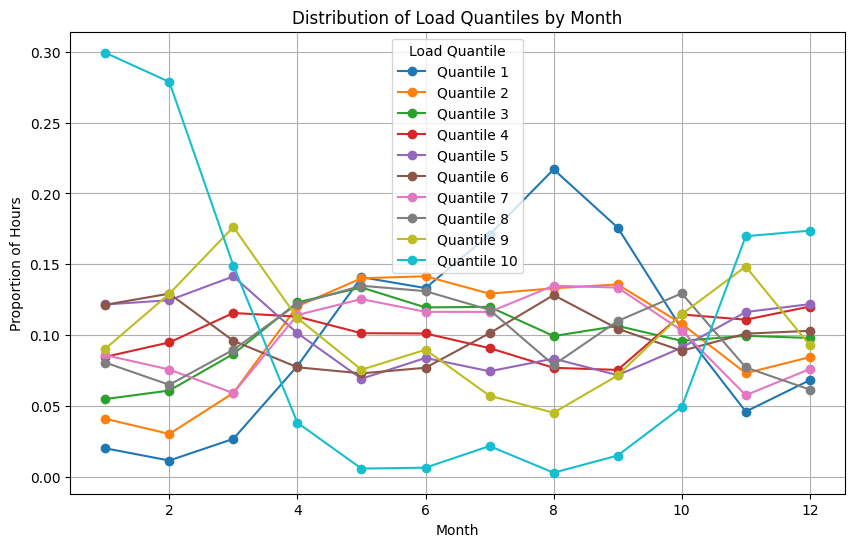

In [18]:
# If we want to see seasonal variation of load quantiles
monthly_quantile_counts = df.groupby("month")["load_quantile"].value_counts().unstack().fillna(0)
monthly_quantile_props = monthly_quantile_counts.div(monthly_quantile_counts.sum(axis=1), axis=0)

plt.figure(figsize=(10,6))
for q in range(1, 11):
    plt.plot(monthly_quantile_props.index, monthly_quantile_props[q], marker='o', label=f'Quantile {q}')

plt.title("Distribution of Load Quantiles by Month")
plt.xlabel("Month")
plt.ylabel("Proportion of Hours")
plt.grid(True)
plt.legend(title="Load Quantile")
plt.show()

# This can reveal seasonal peaks (e.g., winter evening load) and help with capacity planning


In [19]:
monthly_quantile_counts

load_quantile,1,2,3,4,5,6,7,8,9,10
month,,,,,,,,,,
1,180,366,490,756,1086,1084,767,720,807,2672
2,94,247,497,774,1017,1055,618,530,1054,2274
3,239,528,773,1031,1261,856,527,800,1572,1329
4,676,1040,1064,977,876,668,987,1054,968,330
5,1258,1251,1193,905,618,652,1120,1204,675,52
6,1151,1223,1033,874,725,665,1006,1132,775,56
7,1526,1154,1071,811,665,905,1039,1052,511,194
8,1937,1188,887,687,745,1145,1204,705,404,26
9,1520,1173,920,652,620,903,1154,950,618,130


### Interpretation of Temporal Load Quantiles

From these analyses, we can see:

- **Hour-of-day:** High-load quantiles (9-10) mostly occur during **morning and evening peaks**, confirming expected daily demand patterns.  
- **Day-of-week:** High-load hours are more frequent on **weekdays**, reflecting industrial and commercial demand.  
- **Month/Season:** Winter months show a higher proportion of high-load quantiles, which aligns with **heating-related consumption**.  

Knowing **when high-load events occur** is crucial because:

- **Capacity planning:** Utilities can ensure enough generation or flexibility during peak hours.  
- **Risk assessment:** Traders and risk managers know which hours are more likely to experience **high prices or volatility**.  
- **Operational planning:** System operators can schedule **maintenance or demand-response programs** without risking stress during peak hours.  

This temporal analysis sets the stage for **Volatility & Risk Regime Analysis**, because now we know **when the system is stressed**, not just that it is stressed.


In [20]:
df

,load,Price,load_quantile,hour,day,month
timestamp,,,,,,
2022-01-01 00:00:00,42.90350,50.05,2,0,5,1
2022-01-01 00:15:00,42.53274,50.05,2,0,5,1
2022-01-01 00:30:00,42.12637,50.05,2,0,5,1
2022-01-01 00:45:00,41.67822,50.05,1,0,5,1
2022-01-01 01:00:00,41.11334,41.33,1,1,5,1
...,...,...,...,...,...,...
2024-12-31 22:45:00,47.32700,9.06,3,22,1,12
2024-12-31 23:00:00,46.55839,0.52,3,23,1,12
2024-12-31 23:15:00,46.01677,0.52,3,23,1,12


## Step 1: Defining Price Volatility

Before analyzing risk regimes, I first need a **clear and consistent definition of price volatility**.

In electricity markets, volatility reflects:
- How unstable prices are over time
- The level of financial and operational risk
- The likelihood of extreme price movements

Instead of looking at single price values, volatility captures the **variation of prices over a period**.

For this analysis, I will use:
- **Rolling standard deviation of day-ahead prices**

This approach is:
- Easy to interpret
- Widely used in trading and risk analysis
- Suitable for linking volatility to load conditions and time patterns

The idea is simple:
If prices fluctuate strongly over short periods, the market is operating in a **high-risk regime**.


In [113]:
price_series=df['Price'].diff()
price_series.describe()

count    105203.000000
mean         -0.000471
std          12.134040
min        -355.080000
25%           0.000000
50%           0.000000
75%           0.000000
max         423.810000
Name: Price, dtype: float64

In [114]:
#rolling window = 24 hours getting price std for 24 hours

rolling_window=96   # since resolution is 15 minutes
df['price_volatility_24']=price_series.rolling(window=rolling_window).std()
# df[['Price','price_volatility_24']].head(72)

### Interpretation of Rolling Price Volatility

The 24-hour rolling standard deviation measures how much prices fluctuate within a single day. Weekly rolling std can also be used for longer volatility 

- **Low volatility values** indicate stable market conditions  
- **High volatility values** indicate rapid price changes and higher risk  

This metric allows me to:

- Compare volatility across **load quantiles**
- Separate **normal vs high-risk regimes**




In [115]:
avg_volatility_quantile=df.groupby('load_quantile')['price_volatility_24'].mean()
# avg_volatility_load
volatility_stats_per_quantile = (
    df.groupby("load_quantile")["price_volatility_24"]
    .agg(["mean", "median", "min", "max", "std"])
)

volatility_stats_per_quantile

,mean,median,min,max,std
load_quantile,,,,,
1,9.257637,7.974112,0.585815,54.239966,5.836548
2,9.935032,8.339633,0.365677,64.427991,6.734523
3,9.921879,8.306283,0.413990,68.495205,6.875675
4,9.395461,7.883843,1.207737,68.507781,6.239359
5,9.542671,8.086577,1.254421,68.507781,6.331018
6,9.881086,8.485364,1.254995,68.510671,6.470674
7,10.646811,8.880064,1.254995,68.510671,6.698666
8,11.353752,9.144100,1.415831,67.367622,7.226429
9,11.324069,8.533418,2.190655,67.367622,8.241816


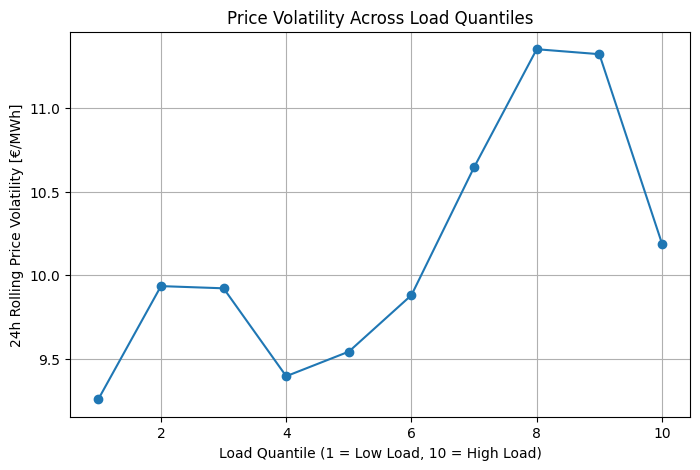

In [116]:
plt.figure(figsize=(8,5))
plt.plot(
    avg_volatility_quantile.index,
    avg_volatility_quantile.values,
    marker='o'
)

plt.title("Price Volatility Across Load Quantiles")
plt.xlabel("Load Quantile (1 = Low Load, 10 = High Load)")
plt.ylabel("24h Rolling Price Volatility [€/MWh]")
plt.grid(True)
plt.show()

### Interpretation: Volatility vs Load

The results show that **price volatility increases as load quantile increases**.
This confirms that higher system load is not only associated with higher prices,
but also with **greater uncertainty and risk**.

In the lower load quantiles, volatility is relatively low and stable,
indicating normal market conditions.

As we move into the upper quantiles, volatility rises significantly,
suggesting that the system becomes more sensitive to small changes in supply or demand.
This effect is especially pronounced close to the previously identified **scarcity threshold**.

From a practical point of view:
- Traders face higher risk exposure during high-load hours
- Utilities must ensure sufficient flexibility during these periods
- High-load quantiles can be interpreted as **high-risk operating regimes**

This analysis strengthens the link between **system tightness and market risk**.


## Step 3: Volatility Across Time — Peak vs Off-Peak Risk

So far, I have shown that volatility increases with load.
However, load itself is not randomly distributed over time.

In electricity markets, **risk is highly time-dependent**:
- Certain hours of the day are structurally riskier
- Peak demand hours tend to coincide with system tightness
- Traders and utilities often manage risk based on **time blocks**, not just prices

In this step, I want to understand:
- Whether price volatility is higher during **peak hours**
- How volatility behaves during **off-peak hours**
- Whether temporal patterns reinforce the load-based risk regimes identified earlier

This analysis is essential for:
- Trading strategies (peak vs off-peak products)
- Utility hedging and dispatch planning
- System operation and reserve management


In [117]:
df["is_peak_hour"] = df["hour"].between(12, 20)

# Quick check
# df[["hour", "is_peak_hour"]].head(96)


In [118]:
volatility_by_time_block = (
    df.groupby("is_peak_hour")["price_volatility_24"]
    .agg(["mean", "median", "min", "max", "std"])
)

In [119]:
volatility_by_time_block

,mean,median,min,max,std
is_peak_hour,,,,,
False,10.130605,8.495850,0.365677,68.510671,6.777985
True,10.169931,8.448039,0.413990,67.367622,6.707611


since there is not much difference in volatiility in peak and off_peak time so i will futher divide time into time of day

In [120]:

conditions = [
    df["hour"].between(5, 11),   # morning 5–12 (5–11 inclusive)
    df["hour"].between(12, 17),  # evening 12–18 (12–17 inclusive)
    df["hour"].between(18, 21),  # late evening 18–22 (18–21 inclusive)
    (df["hour"].between(22, 23)) | (df["hour"].between(0, 4))  # night 22–5
]

choices = np.array(["morning", "afternoon", "evening", "night"], dtype=object)
df["time_of_day"] = np.select(conditions, choices, default="night")

In [121]:
volatility_by_time_day = (
    df.groupby("time_of_day")["price_volatility_24"]
    .agg(["mean", "median", "min", "max", "std"])
)
volatility_by_time_day 

,mean,median,min,max,std
time_of_day,,,,,
afternoon,10.160516,8.424630,0.860738,62.242314,6.720338
evening,10.175084,8.487675,0.366749,68.510671,6.706419
morning,10.137358,8.526629,0.819181,68.491361,6.757989
night,10.123358,8.483578,0.365677,68.507781,6.798019


In [122]:
df['price_volatility_24'].describe()

count    105108.000000
mean         10.145354
std           6.751673
min           0.365677
25%           5.873803
50%           8.483187
75%          12.100215
max          68.510671
Name: price_volatility_24, dtype: float64

In [123]:

high_load_df = df[df["load_quantile"] >= 9]

volatility_peak_high_load = (
    high_load_df.groupby("is_peak_hour")["price_volatility_24"]
    .mean()
)

volatility_peak_high_load

is_peak_hour
False    10.853223
True     10.688724
Name: price_volatility_24, dtype: float64

In [124]:
df.columns

Index(['load', 'Price', 'load_quantile', 'hour', 'day', 'month',
       'price_volatility_24', 'is_peak_hour', 'time_of_day'],
      dtype='object')

In [125]:
day_basis_volatility= df.groupby('month')['price_volatility_24'].agg(['mean','std','max','min'])

In [126]:
day_basis_volatility

,mean,std,max,min
month,,,,
1,6.547967,2.964725,16.563931,0.585815
2,6.866571,3.119988,20.501937,1.629837
3,9.608540,6.192899,40.121063,2.307291
4,8.630782,2.916702,16.839723,1.900806
5,8.660769,2.705516,16.408178,3.308772
6,9.795488,4.181662,26.806395,3.205599
7,12.690808,6.865793,43.780317,2.572307
8,13.617964,7.340141,48.638125,2.935647
9,16.617268,9.678907,54.467035,4.193208


In [153]:
daily_counts = df.groupby([df.index.date, 'load_quantile']).size().unstack(fill_value=0)

# daily_counts: rows = date, columns = quantile, values = number of hours
# daily_counts.tail()
daily_max_quantile = daily_counts.idxmax(axis=1)      # which quantile occurred most
daily_max_count = daily_counts.max(axis=1)           # number of hours
daily_min_quantile = daily_counts.idxmin(axis=1)
daily_min_count = daily_counts.min(axis=1)

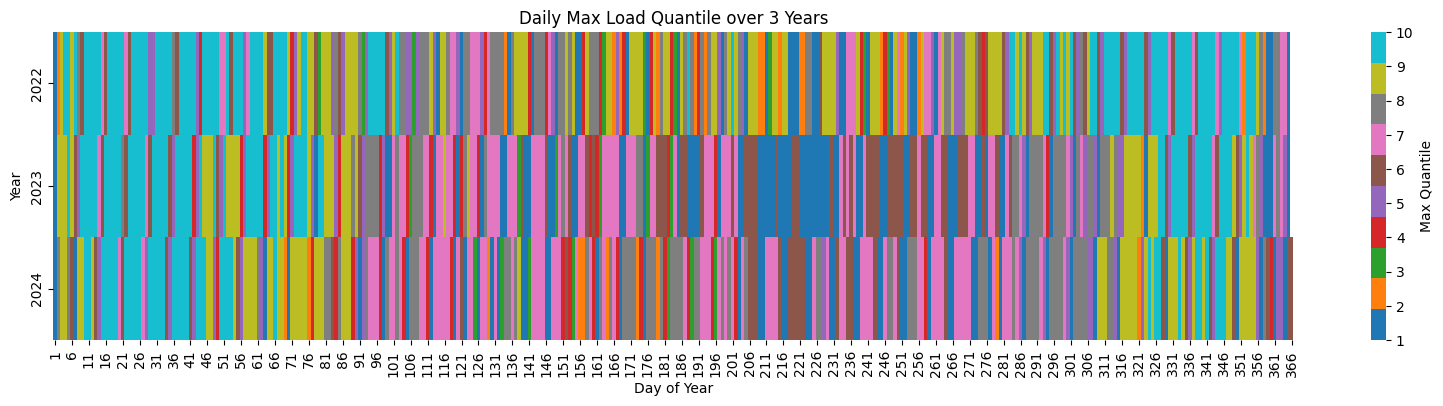

In [ ]:
import seaborn as sns


# Prepare dataframe for heatmap
heatmap_df = daily_max_quantile.to_frame(name='max_quantile')
heatmap_df['day'] = pd.to_datetime(heatmap_df.index)

# Pivot to year x day-of-year if you want a nice calendar-like heatmap
heatmap_df['year'] = heatmap_df['day'].dt.year
heatmap_df['day_of_year'] = heatmap_df['day'].dt.dayofyear

pivot = heatmap_df.pivot(index='year', columns='day_of_year', values='max_quantile')

plt.figure(figsize=(20,4))
sns.heatmap(pivot, cmap='tab10', cbar_kws={'label':'Max Quantile'})
plt.xlabel('Day of Year')
plt.ylabel('Year')
plt.title('Daily Max Load Quantile over 3 Years')
plt.show()
